2026-02-18 10:50:23 [INFO] [commstools/backend.py] CuPy is available and functional, defaulting Signals to GPU.


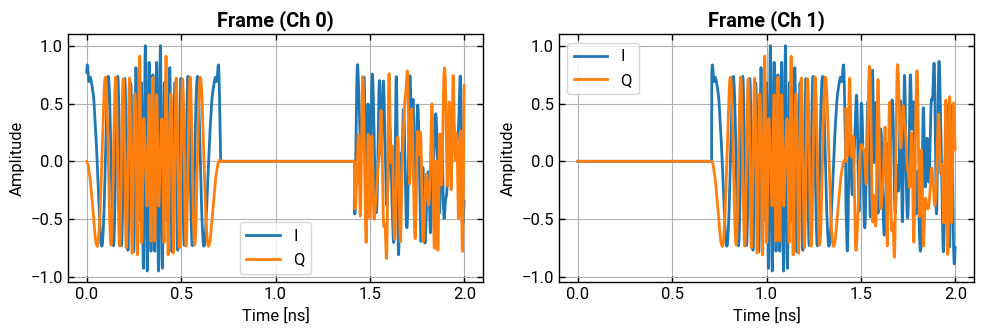

In [1]:
# imports
from commstools.core import Preamble, SingleCarrierFrame
from commstools.logger import set_log_level

set_log_level("INFO")


symbol_rate = 100e9
sampling_rate = 800e9
sps = int(sampling_rate / symbol_rate)
pilots_mod_scheme = "psk"
pilots_mod_order = 8
payload_mod_scheme = "qam"
payload_mod_order = 32

p = Preamble(sequence_type="zc", length=71)

f = SingleCarrierFrame(
    payload_len=800000,
    payload_seed=42,
    payload_mod_scheme=payload_mod_scheme,
    payload_mod_order=payload_mod_order,
    preamble=p,
    pilot_pattern="comb",
    pilot_period=10,
    pilot_block_len=1,
    pilot_seed=1337,
    pilot_mod_scheme=pilots_mod_scheme,
    pilot_mod_order=pilots_mod_order,
    pilot_gain_db=0.0,
    num_streams=2,
    preamble_mode="time_orthogonal",
)

fs = f.to_signal(sps=sps, symbol_rate=symbol_rate, pulse_shape="rrc")
fs.plot_symbols(show=True, num_symbols=200, title="Frame")


2026-02-18 10:50:28 [INFO] [commstools/impairments.py] Adding AWGN (Es/N0 target: 30.00 dB).


2026-02-18 10:50:28 [INFO] [commstools/core.py] Generating shaping filter taps (shape: rrc).


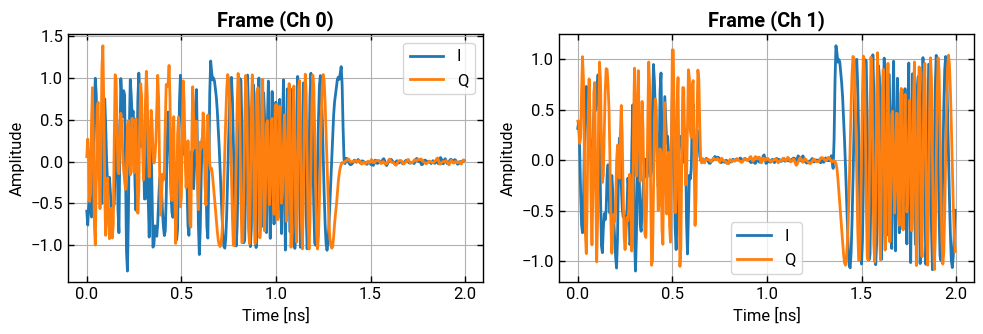

2026-02-18 10:50:28 [INFO] [commstools/sync.py] Channels aligned (spread 0).


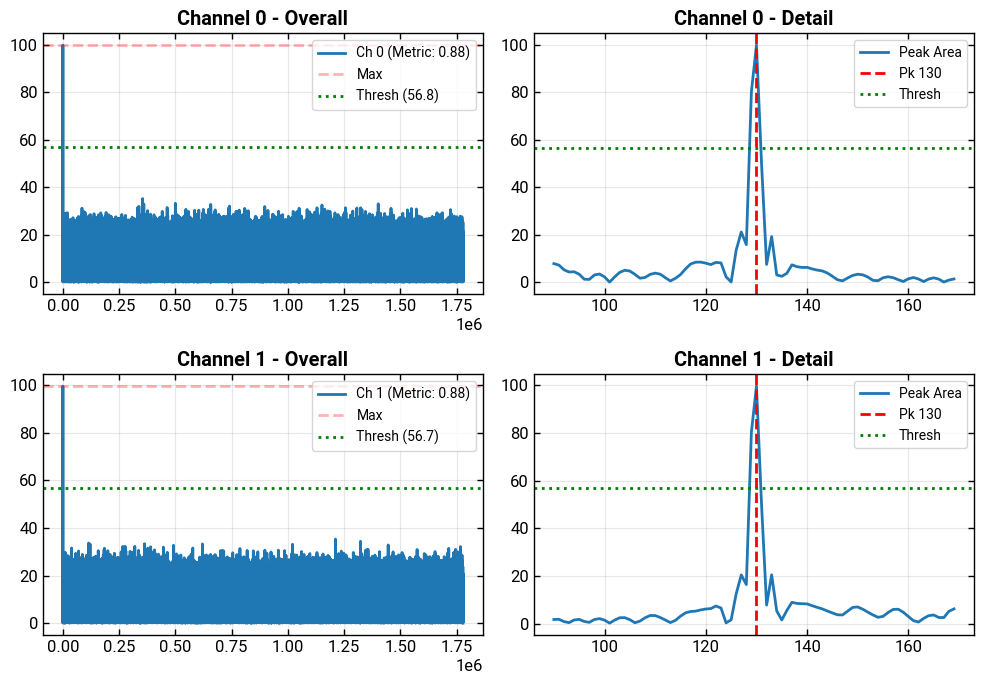

2026-02-18 10:50:29 [INFO] [commstools/sync.py] Timing estimated. Coarse: [130, 130], Fractional: [-0.2430283579248993, -0.24512304499563697], Metrics: [0.8799413554297971, 0.8782451118562609]


In [2]:
from commstools.backend import get_array_module
from commstools.impairments import add_awgn
from commstools.sync import correct_timing, estimate_timing

rxfs = fs.copy()
xp = get_array_module(rxfs.samples)

rxfs.samples = add_awgn(rxfs.samples, esn0_db=30, sps=rxfs.sps)
rxfs.samples = xp.roll(rxfs.samples, 519, axis=-1)
rxfs.resample(sps_out=2)

rxfs.matched_filter()
rxfs.plot_symbols(show=True, num_symbols=200, title="Frame")

fix = estimate_timing(rxfs, p, debug_plot=True, dft_upsample=16)
# print(fix)


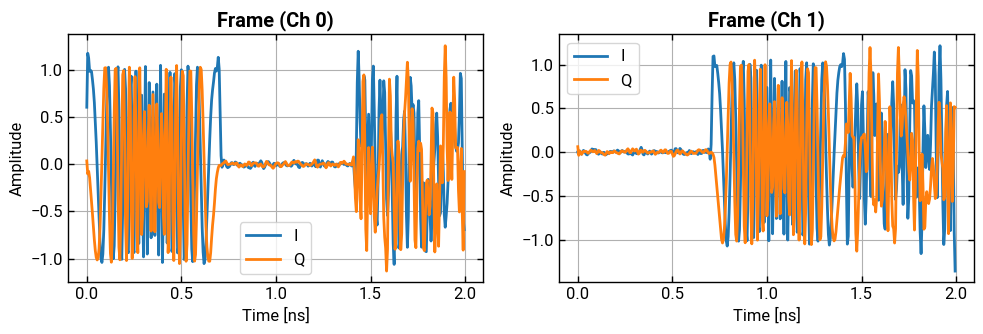

In [3]:
rxfs.samples = correct_timing(rxfs.samples, fix[0], fix[1])

rxfs.plot_symbols(show=True, num_symbols=200, title="Frame")


In [4]:
ps = p.to_signal(sps=rxfs.sps, symbol_rate=symbol_rate, pulse_shape="rrc")

rxfs.samples = rxfs.samples[:, 2 * ps.samples.shape[-1] :]


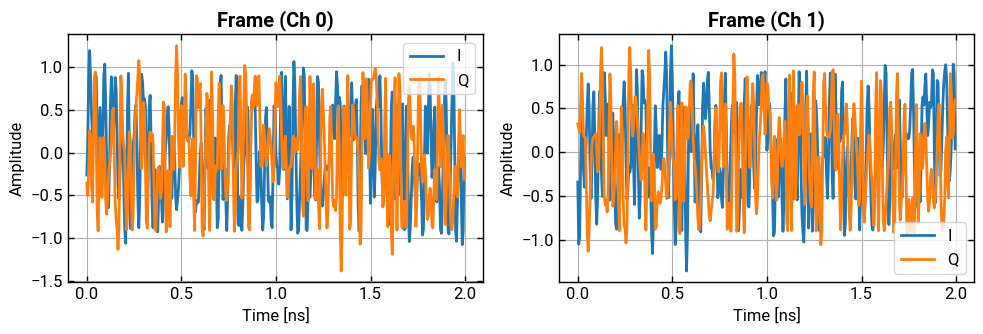

In [5]:
rxfs.plot_symbols(show=True, num_symbols=200, title="Frame")


In [6]:
rxfs.decimate_to_symbol_rate(offset=0)
map = f.get_structure_map(unit="samples", sps=rxfs.sps, include_preamble=False)


In [7]:
pilots = rxfs.copy()
pilots.source_symbols = f.pilot_symbols
pilots.source_bits = f.pilot_bits
pilots.samples = pilots.samples[:, map["pilots"]]

payload = rxfs.copy()
payload.source_symbols = f.payload_symbols
payload.source_bits = f.payload_bits
payload.samples = payload.samples[:, map["payload"]]


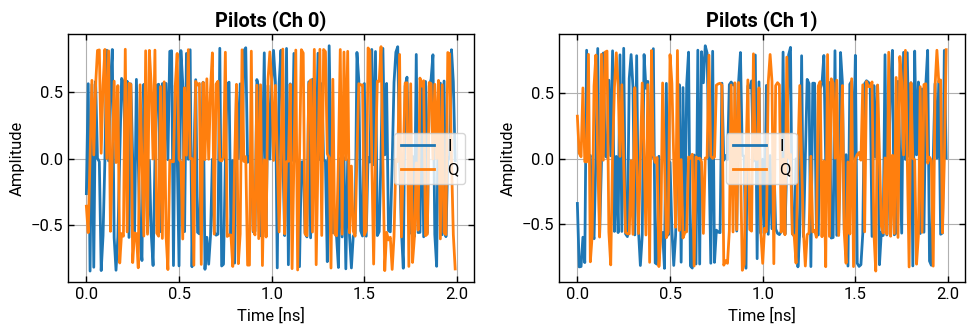

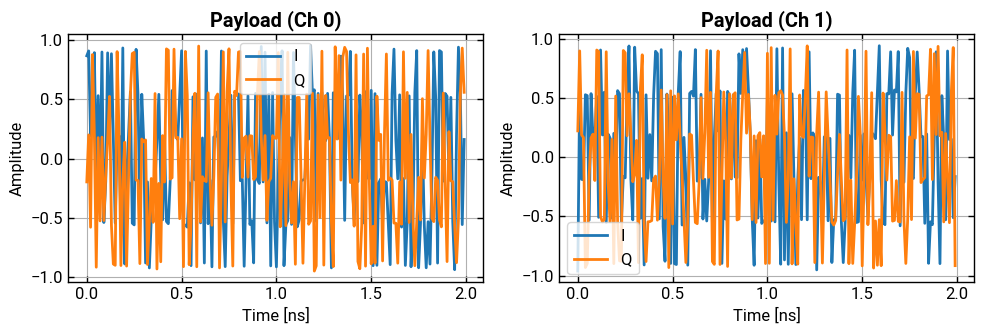

In [8]:
pilots.plot_symbols(show=True, num_symbols=200, title="Pilots")
payload.plot_symbols(show=True, num_symbols=200, title="Payload")


In [9]:
payload.modulation_scheme = payload_mod_scheme
payload.modulation_order = payload_mod_order
pilots.modulation_scheme = pilots_mod_scheme
pilots.modulation_order = pilots_mod_order


In [22]:
payload.resolve_symbols()
pilots.resolve_symbols()
payload.demap_symbols(hard=False, noise_var=10)
pilots.demap_symbols(hard=False, noise_var=10)


2026-02-18 10:57:56 [INFO] [commstools/core.py] Signal already at 1 sps, no downsampling needed.
2026-02-18 10:57:56 [INFO] [commstools/core.py] Signal already at 1 sps, no downsampling needed.


array([[-0.12503831, -0.02010798, -0.04346356, ...,  0.20784615,
        -0.06026778, -0.06112895],
       [ 0.03174224, -0.11978402,  0.0364681 , ...,  0.19705297,
        -0.05373716, -0.05936336]], shape=(2, 266667), dtype=float32)

In [ ]:
payload.resolved_llr
pilots.resolved_llr


array([[-0.12503831, -0.02010798, -0.04346356, ...,  0.20784615,
        -0.06026778, -0.06112895],
       [ 0.03174224, -0.11978402,  0.0364681 , ...,  0.19705297,
        -0.05373716, -0.05936336]], shape=(2, 266667), dtype=float32)

In [ ]:
payload.resolve_symbols()
pilots.resolve_symbols()
payload.demap_symbols()
pilots.demap_symbols()


In [23]:
payload.evm()
payload.snr()
payload.ber()


2026-02-18 10:58:00 [INFO] [commstools/metrics.py] EVM Ch0: 3.25% (-29.75 dB)
2026-02-18 10:58:00 [INFO] [commstools/metrics.py] EVM Ch1: 3.24% (-29.78 dB)


2026-02-18 10:58:00 [INFO] [commstools/metrics.py] SNR Ch0: 29.75 dB
2026-02-18 10:58:00 [INFO] [commstools/metrics.py] SNR Ch1: 29.78 dB
2026-02-18 10:58:00 [INFO] [commstools/metrics.py] BER Ch0: 2.50e-07 (1/4000000 errors)
2026-02-18 10:58:00 [INFO] [commstools/metrics.py] BER Ch1: 5.00e-07 (2/4000000 errors)


array([2.5e-07, 5.0e-07])

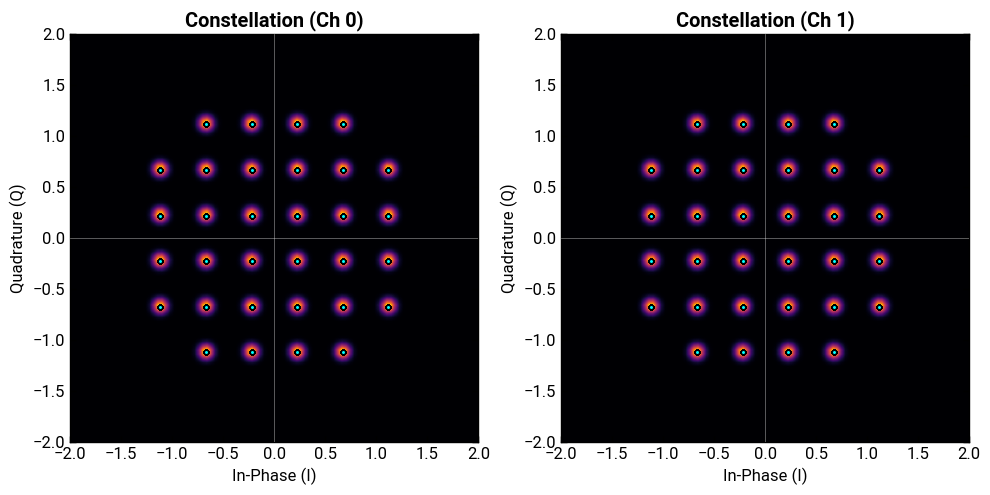

In [34]:
payload.plot_constellation(data="resolved", overlay_source=True, show=True)


In [25]:
pilots.evm()
pilots.snr()
pilots.ber()


2026-02-18 10:36:01 [INFO] [commstools/metrics.py] EVM Ch0: 3.26% (-29.73 dB)
2026-02-18 10:36:01 [INFO] [commstools/metrics.py] EVM Ch1: 3.25% (-29.77 dB)
2026-02-18 10:36:01 [INFO] [commstools/metrics.py] SNR Ch0: 29.73 dB
2026-02-18 10:36:01 [INFO] [commstools/metrics.py] SNR Ch1: 29.77 dB
2026-02-18 10:36:01 [INFO] [commstools/metrics.py] BER Ch0: 0.00e+00 (0/266667 errors)
2026-02-18 10:36:01 [INFO] [commstools/metrics.py] BER Ch1: 0.00e+00 (0/266667 errors)


array([0., 0.])

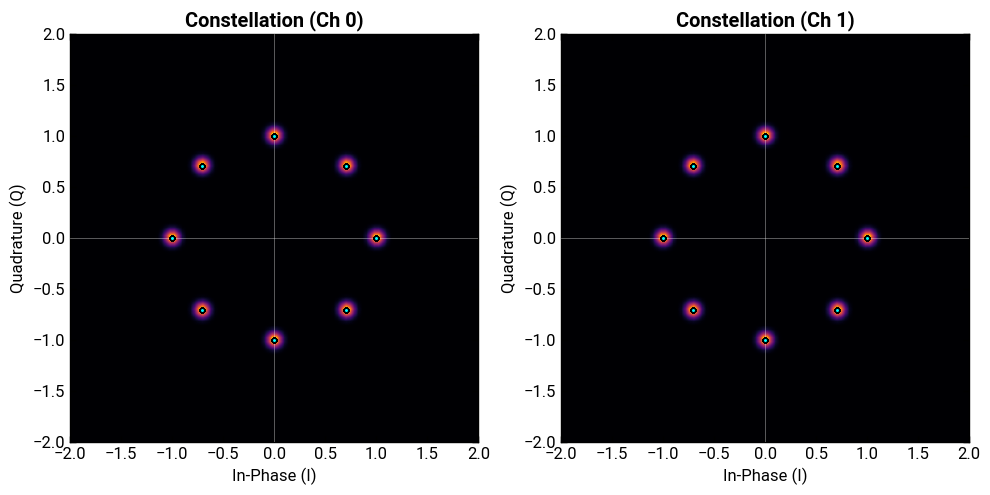

In [26]:
pilots.plot_constellation(data="resolved", overlay_source=True, show=True)
